# HW2: Local Planning

### EECE 5550: Mobile Robotics (Spring 2025)


**Collaboration Statement:**

In [2]:
# Fill this in per the syllabus, or we will assign a zero to this assignment.
# Did not collaborate with anyone
# Referred the following links:

#https://github.com/MizuhoAOKI/python_simple_mppi
#https://www.youtube.com/watch?v=Jkc5d_bisTc
#https://www.youtube.com/watch?v=USaishDES9s
#https://www.cvxpy.org/tutorial/intro/index.html

# Installation

This semester, we will use a custom simulator, called `gym-neu-racing`, to develop navigation algorithms. We implemented the basic structure of this simulator for you, and the HW assignments will ask you to implement important functions (e.g., kinematics, sensing, planning, mapping).

To install the simulator, you can use this command (it will download the latest code from GitLab and automatically install it in the environment your Colab notebook runs in):

In [3]:
!pip install git+https://gitlab.com/neu-autonomy/gym-neu-racing.git

  Cloning https://gitlab.com/neu-autonomy/gym-neu-racing.git to /tmp/pip-req-build-jnaxrvyq
  Running command git clone --filter=blob:none --quiet https://gitlab.com/neu-autonomy/gym-neu-racing.git /tmp/pip-req-build-jnaxrvyq
  Resolved https://gitlab.com/neu-autonomy/gym-neu-racing.git to commit 60f6a0e80b5ae6dd14fb13a837c252d0d88fe571
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 45.4 MB/s eta 0:00:00
  Created wheel for gym_neu_racing: filename=gym_neu_racing-0.0.1-py3-none-any.whl size=65573 sha256=8b14e1dd8e9517ce67c6c019d58123760d129198967577c2ef174281866001c6
  Stored in directory: /tmp/pip-ephem-wheel-cache-11ltnavw/wheels/4f/e1/e1/050619ec6014120d47555de901a265d190efdd96f993c95344
Successfully built gym_neu_racing


Now that the simulator and its dependencies have been installed, you can import the modules you'll need for this assignment:

In [4]:
import gymnasium
import numpy as np
import gym_neu_racing
from gymnasium import spaces
from gym_neu_racing.envs.wrappers import StateFeedbackWrapper
import matplotlib.pyplot as plt
from typing import Callable
import matplotlib.cm as cmx
import matplotlib.colors as colors
from gym_neu_racing import motion_models
import cvxpy as cp

# Problem 1: MPPI

## 1a) MPPI to move toward a goal coordinate

In this problem, you'll implement a basic version of MPPI and show that it outputs a good rollout to move a robot toward a given goal position. This part uses the Unicycle kinematic model that's built into the simulator. You should  make sure that your `get_action` method considers the control limits (otherwise it may command things that the robot can't execute), which may require passing those as arguments to the `__init__` method.

You will probably need to experiment with different numbers of rollouts, cost functions, λ values, numbers of iterations, etc. to get good performance.

Keeping this code relatively organized and clean will help for later parts in the assignment, where you build on this implementation. For example, you are encouraged to define helper methods in your `MPPI` class to help keep your code organized (e.g., you may want a `score_rollouts` and/or `plot_rollouts` method that get called inside the `get_next_action` method).

**Deliverables**:
- Implement the `MPPI` class, in particular the `get_next_action` method, so that the chosen rollout drives the robot toward the goal position.
- Print the best control sequence your MPPI algorithm came up with (the first row/element of this sequence should be the action that your `get_action` returns)
- Include a plot that shows the rollouts, start position, goal position, and highlights the best rollout in that iteration, for at least a few iterations. We expect that the later iterations will give much better rollouts than the first iteration. You should make your axes have the same scale (e.g., using `plt.axis('equal')`).

In [5]:
# Create an instance of the mobile robot simulator we'll use this semester
env = gymnasium.make("gym_neu_racing/NEUEmptyWorld-v0")

# Tell the simulator to directly provide the current state vector (no sensors yet)
env = StateFeedbackWrapper(env)

In [6]:
class MPPI:
    def __init__(
        self,
        motion_model=motion_models.Unicycle(),
        num_rollouts=100,
        window=9,
        lambda_=0.15,
        num_iterations=4,
        control_limits=[[0.9, -np.pi],  # Lower bounds for [velocity, steering]
                        [2, np.pi]]   # Upper bounds for [velocity, steering]
    ):
        self.motion_model = motion_model
        self.num_rollouts = num_rollouts
        self.window = window
        self.lambda_ = lambda_
        self.num_iterations = num_iterations
        self.control_limits = np.array(control_limits)

    def get_action(self, initial_state: np.ndarray, goal_pos: np.ndarray) -> np.ndarray:
        # Initialize control sequence
        control_sequence = np.zeros((self.window, 2))

        for iteration in range(self.num_iterations):
            # Generate noise for control inputs
            noise = np.random.normal(0, 1, (self.num_rollouts, self.window, 2))

            # Generate rollouts
            rollouts = self.generate_rollouts(initial_state, control_sequence, noise)

            # Score rollouts
            costs = self.score_rollouts(rollouts, goal_pos)

            # Compute importance weights based on costs
            weights = self.compute_weights(costs)

            # Update control sequence using weighted noise
            control_sequence += np.sum(weights[:, np.newaxis, np.newaxis] * noise, axis=0)

            # Keep controls within limits
            control_sequence = np.clip(control_sequence, self.control_limits[0], self.control_limits[1])

            self.plot_rollouts(rollouts, initial_state, goal_pos, costs, iteration)

            print("Best control sequence:")
            for i in range(len(control_sequence)):
                print(f"Step {i + 1}: Velocity = {control_sequence[i][0]:.4f}, Steering = {control_sequence[i][1]:.4f}") # Print the best control sequence in each iteration

        return control_sequence[0]

    def generate_rollouts(self, initial_state, control_sequence, noise):
        # Initialize rollouts (each rollout has (window + 1) states)
        rollouts = np.zeros((self.num_rollouts, self.window + 1, 3))
        rollouts[:, 0] = initial_state  # Set initial state

        # Simulate motion for each time step
        for t in range(self.window):
            # Apply control with noise
            controls = np.clip(control_sequence[t] + noise[:, t], self.control_limits[0], self.control_limits[1])
            # Propagate motion
            rollouts[:, t + 1] = self.motion_model.step(rollouts[:, t], controls)

        return rollouts

    def score_rollouts(self, rollouts, goal_pos):
        # Compute costs based on final distance to goal
        final_positions = rollouts[:, -1, :2]
        costs = np.sum((final_positions - goal_pos)**2, axis=1)
        return costs

    def compute_weights(self, costs):
        #Compute importance weights for MPPI based on costs.
        exp_costs = np.exp(-1 / self.lambda_ * (costs - np.min(costs)))  # Normalize costs
        return exp_costs / np.sum(exp_costs)


    def compute_exp(self, costs):
        exp_costs = np.exp(-1/self.lambda_ * (costs - np.min(costs)))
        return exp_costs / np.sum(exp_costs)

    def plot_rollouts(self, rollouts, initial_state, goal_pos, costs, iteration):

        plt.figure(figsize=(10, 10))
        plt.scatter(rollouts[:, :, 0], rollouts[:, :, 1], c='lightgray', s=1)
        plt.scatter(initial_state[0], initial_state[1], c='green', s=100, label='Start')
        plt.scatter(goal_pos[0], goal_pos[1], c='red', s=100, label='Goal')

        best_rollout = rollouts[np.argmin(costs)]
        plt.plot(best_rollout[:, 0], best_rollout[:, 1], c='blue', linewidth=2, label='Best Rollout')

        plt.legend()
        plt.axis('equal')
        plt.title(f'MPPI Rollouts (Iteration {iteration + 1})')
        plt.show()


You can use the following code to check whether your MPPI implementation is working. After tuning your algorithm, it should be able to come up with a rollout that ends close to the goal (within 0.1m in l2 distance is close enough):

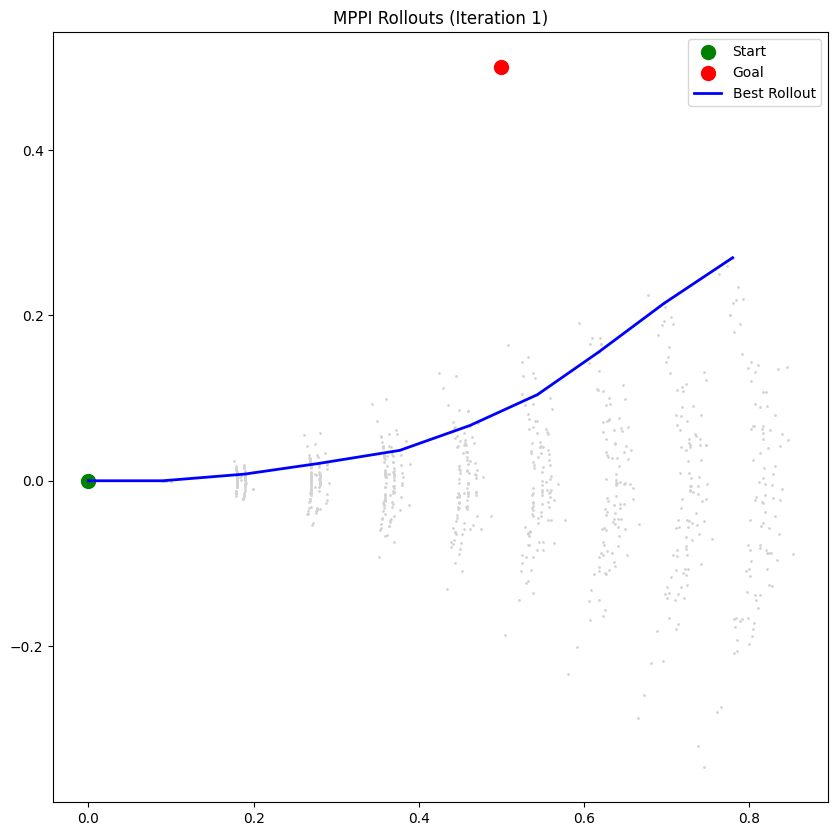

Best control sequence:
Step 1: Velocity = 0.9000, Steering = 0.6015
Step 2: Velocity = 0.9000, Steering = 0.2603
Step 3: Velocity = 0.9000, Steering = 0.3518
Step 4: Velocity = 0.9000, Steering = 0.1558
Step 5: Velocity = 0.9000, Steering = 0.1811
Step 6: Velocity = 0.9000, Steering = 0.2440
Step 7: Velocity = 0.9000, Steering = -0.2589
Step 8: Velocity = 0.9000, Steering = 0.0757
Step 9: Velocity = 0.9000, Steering = -0.1302


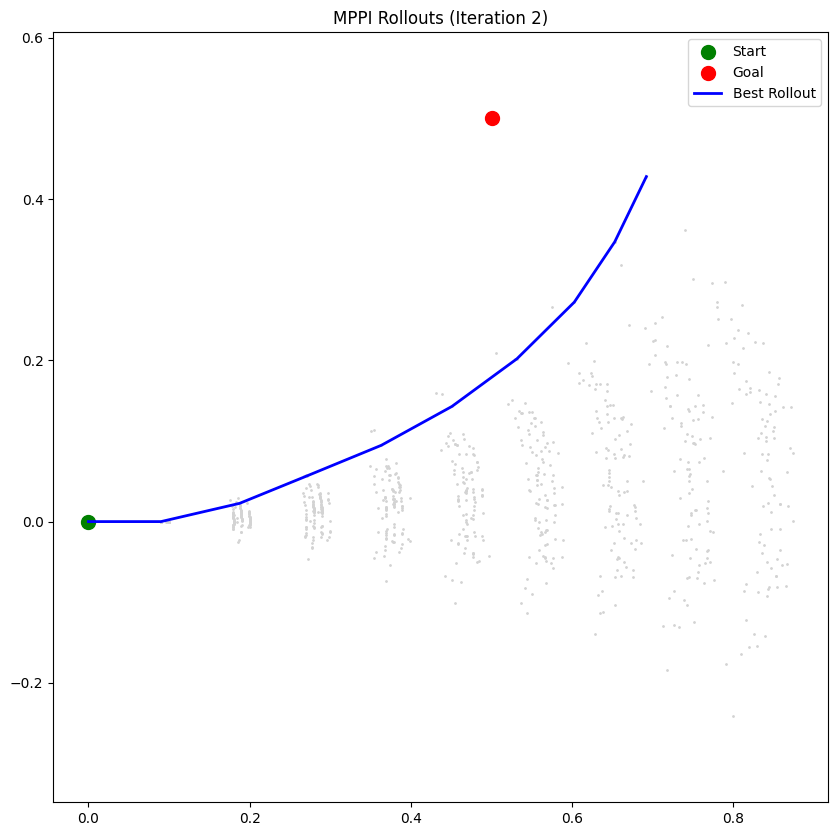

Best control sequence:
Step 1: Velocity = 0.9000, Steering = 0.9867
Step 2: Velocity = 1.0219, Steering = 0.4538
Step 3: Velocity = 0.9252, Steering = 0.6012
Step 4: Velocity = 0.9000, Steering = 0.4815
Step 5: Velocity = 1.0069, Steering = 0.3181
Step 6: Velocity = 0.9000, Steering = 0.3302
Step 7: Velocity = 0.9000, Steering = -0.2039
Step 8: Velocity = 1.0053, Steering = 0.0758
Step 9: Velocity = 0.9000, Steering = -0.1410


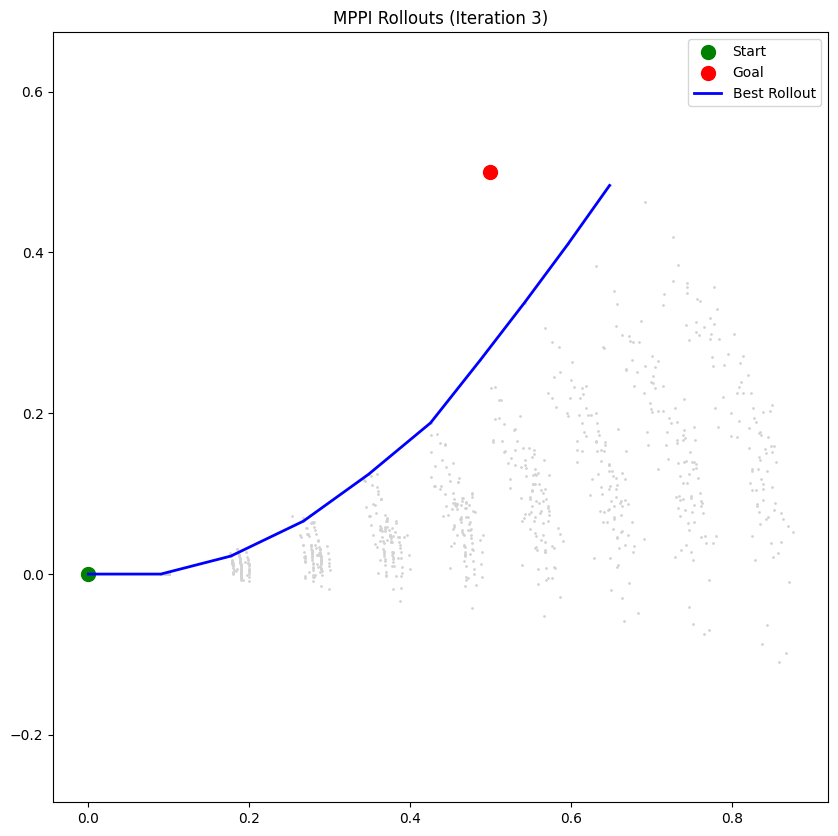

Best control sequence:
Step 1: Velocity = 0.9000, Steering = 1.4331
Step 2: Velocity = 1.0054, Steering = 0.7401
Step 3: Velocity = 0.9193, Steering = 0.9016
Step 4: Velocity = 0.9000, Steering = 0.5445
Step 5: Velocity = 1.0891, Steering = 0.6967
Step 6: Velocity = 0.9000, Steering = 0.4736
Step 7: Velocity = 0.9000, Steering = -0.1138
Step 8: Velocity = 0.9922, Steering = 0.1088
Step 9: Velocity = 0.9736, Steering = -0.2406


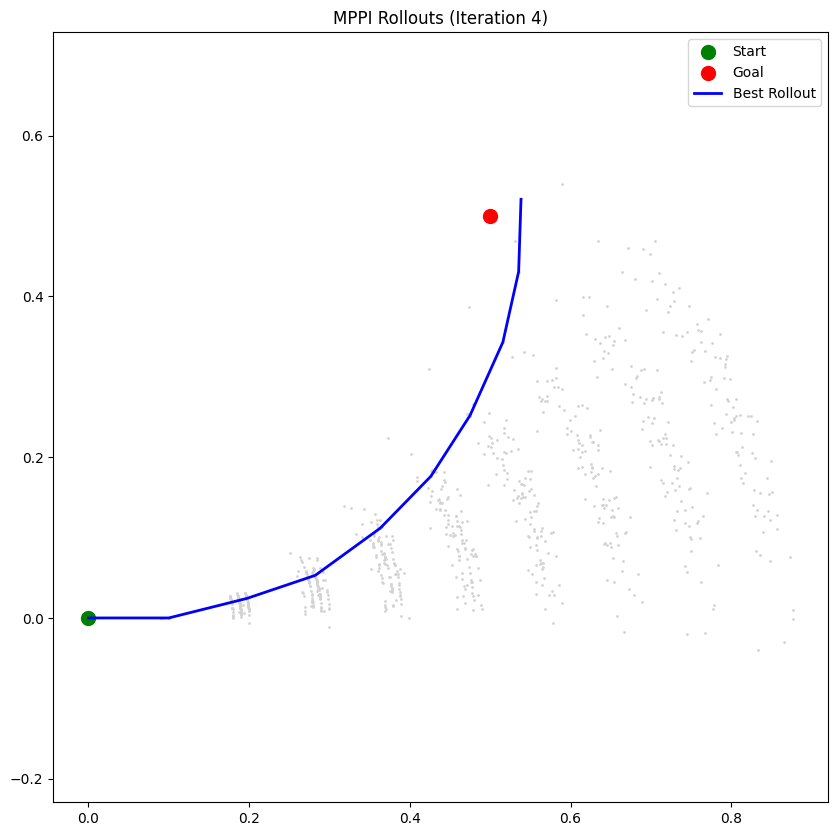

Best control sequence:
Step 1: Velocity = 1.0700, Steering = 1.9060
Step 2: Velocity = 1.0588, Steering = 1.0539
Step 3: Velocity = 0.9000, Steering = 1.1810
Step 4: Velocity = 0.9000, Steering = 0.7299
Step 5: Velocity = 0.9878, Steering = 0.7238
Step 6: Velocity = 0.9000, Steering = 0.4299
Step 7: Velocity = 0.9000, Steering = -0.1446
Step 8: Velocity = 0.9123, Steering = 0.2635
Step 9: Velocity = 0.9000, Steering = -0.3059


In [7]:
# Initialize the environment (and set random seed so any randomness is repeatable)
np.random.seed(0)
obs, _ = env.reset()

# Set the starting state (x, y, theta) and goal position (x, y).
initial_state = np.array([0.0, 0.0, 0.0])
goal_pos = np.array([0.5, 0.5])

# Instantiate your contoller class
controller = MPPI()

# Run your control algorithm for 1 step. We'll worry about running your
# algorithm in closed-loop in later parts of the assignment.
action = controller.get_action(initial_state, goal_pos)

## 1b) MPPI to drive around a racetrack

Now you will extend your MPPI implementation so that your robot drives around a racetrack. There are a few interesting challenges you'll need to figure out that didn't appear in the earlier problem:

*   How to score rollouts? Some possible ideas include placing waypoints around the track, designing a cost-to-go function, or encouraging the vehicle to maintain full speed, but this is completely up to you!
*   How to ensure the robot doesn't collide with the walls? You can transform coordinates from the world frame to map cell indices using `self.static_map.world_coordinates_to_map_indices(states_in_world)` and `self.static_map.static_map[map_indices]` to check whether a cell of the map is occupied or free.

**Deliverables**:
- Implement the `MPPIRacetrack` class below to enable your robot to complete a full lap around the track
- Generate a plot of the path taken with some indication of time (e.g., using a colorbar, timestamps every so often along the path, or another creative way you come up with)

In [8]:
# Create an instance of the mobile robot simulator we'll use this semester
env = gymnasium.make("gym_neu_racing/NEURacing-v0")

# Tell the simulator to directly provide the current state vector (no sensors yet)
env = StateFeedbackWrapper(env)

**SOLUTION:** The MPPIRacetrack class aims at driving the unicycle model robot around a racetrack for 3 laps. The idea is to extract the map indices using self.static_map.world_coordinates_to_map_indices and use self.static_map.static_map[map_indices] to check boundary collision and drive the robot at a constant velocity. The cost function is penalized if the robot collides with the wall/boundary. To reduce the numsteps, the distance from center of the race track is also taken into account. The cost function is penalized if the robot moves away from the inner track radius which forces a path near the inner circumference of the track.

In [9]:
class MPPIRacetrack:
    def __init__(
        self,
        static_map,
        motion_model=motion_models.Unicycle(),
        num_rollouts=100,
        horizon=10,
        lambda_=1,
        steering_limit=[-np.pi/6, np.pi/6],  # Steering angle limits
        constant_velocity=10.0  # Fixed velocity
    ):
        self.motion_model = motion_model
        self.static_map = static_map
        self.num_rollouts = num_rollouts
        self.horizon = horizon
        self.lambda_ = lambda_
        self.steering_limit = np.array(steering_limit)
        self.constant_velocity = constant_velocity  # Velocity stays constant

        # Track path for visualization
        self.path = []
        self.timestamps = []

    ### MPPI Core Functions ###
    def get_action(self, initial_state: np.array) -> np.array:
        # Initialize control sequence (steering only)
        control_sequence = np.zeros((self.horizon, 1))
        # Add noise for rollouts (steering angle variations)
        noise = np.random.normal(0, 1, (self.num_rollouts, self.horizon, 1))

        # Simulate rollouts using noise
        rollouts = self.generate_rollouts(initial_state, control_sequence, noise)
        # Compute costs for each rollout
        costs = self.score_rollouts(rollouts)
        # Compute importance weights based on costs
        weights = self.compute_weights(costs)

        # Update control sequence using weighted noise
        control_sequence += np.sum(weights[:, np.newaxis, np.newaxis] * noise, axis=0)
        # Keep steering within limits
        control_sequence = np.clip(control_sequence, self.steering_limit[0], self.steering_limit[1])

        # Store current position for visualization
        self.path.append(initial_state[:2])
        self.timestamps.append(len(self.path))

        # Return constant velocity + best steering action
        return np.array([self.constant_velocity, control_sequence[0, 0]])

    def generate_rollouts(self, initial_state, control_sequence, noise):
        # Initialize rollouts (each rollout has (horizon + 1) states)
        rollouts = np.zeros((self.num_rollouts, self.horizon + 1, 3))
        rollouts[:, 0] = initial_state  # Set initial state

        # Simulate motion for each time step
        for t in range(self.horizon):
            # Apply steering control with noise
            steering_angles = np.clip(control_sequence[t] + noise[:, t], self.steering_limit[0], self.steering_limit[1])
            # Create control inputs (constant velocity + noisy steering)
            controls = np.column_stack((np.full(self.num_rollouts, self.constant_velocity), steering_angles))
            # Propagate motion
            rollouts[:, t + 1] = self.motion_model.step(rollouts[:, t], controls)

        return rollouts

    def score_rollouts(self, rollouts):
        costs = np.zeros(self.num_rollouts)  # Store cost for each rollout

        for i in range(self.num_rollouts):
            world_coords = rollouts[i, :, :2].reshape(-1, 2)  # Extract x, y positions

            # Compute initial and final distance from center (0,0)
            initial_radius = np.linalg.norm(world_coords[0])
            final_radius = np.linalg.norm(world_coords[-1])

            # Penalize moving away from the center
            costs[i] += 10 * (final_radius - initial_radius)

            # Check collisions with obstacles
            indices, valid = self.static_map.world_coordinates_to_map_indices(world_coords)
            if valid.any():
                valid_indices = indices[valid]
                # Add high cost for collisions
                costs[i] += 10 * np.sum(self.static_map.static_map[valid_indices[:, 0], valid_indices[:, 1]] != 0)

        return costs

    def compute_weights(self, costs):
        #Compute importance weights for MPPI based on costs
        exp_costs = np.exp(-1 / self.lambda_ * (costs - np.min(costs)))  # Normalize costs
        return exp_costs / np.sum(exp_costs)  # Convert to probabilities

    def plot_path(self):
        #Plot the robot's path
        path = np.array(self.path)

        plt.figure(figsize=(10, 10))
        scatter = plt.scatter(path[:, 0], path[:, 1], c=self.timestamps, cmap='viridis', label="Path")

        # Add colorbar for timestamps
        plt.colorbar(scatter, label='Timestamp')

        plt.xlabel('X position')
        plt.ylabel('Y position')
        plt.title('Robot Path on Racetrack')
        plt.grid(True)
        plt.axis('equal')


lap completed!
clockwise -> fwd lap completed
lap completed!
clockwise -> fwd lap completed
lap completed!
clockwise -> fwd lap completed


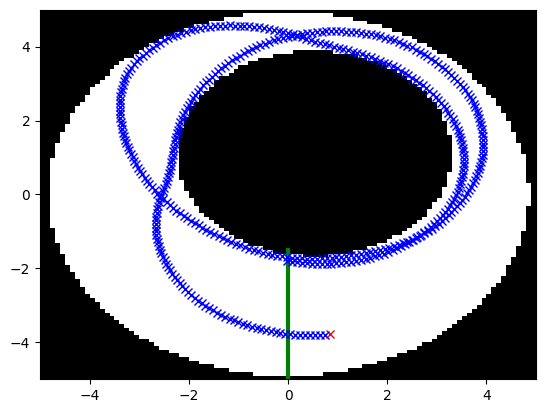

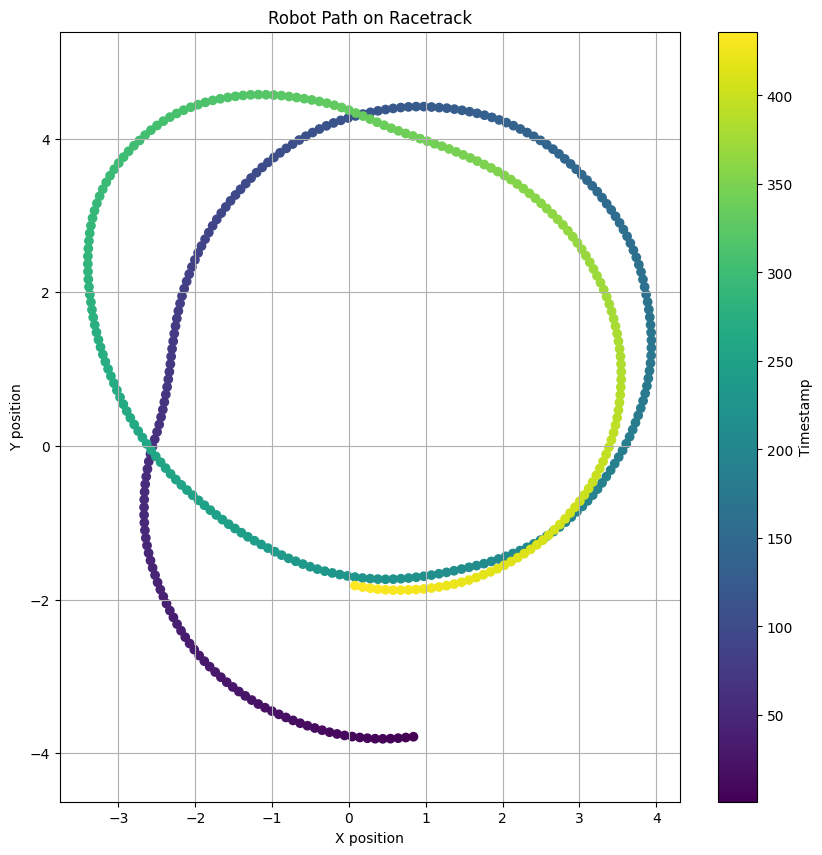

num timesteps used: 435


In [10]:
def run_planner_on_racetrack(
    env: gymnasium.Env,
    planner_class=MPPIRacetrack,
    seed: int = 0,
    num_laps: int = 3,
) -> int:

    np.random.seed(seed)
    obs, _ = env.reset()
    env.unwrapped.laps_left = num_laps

    # Create an instance of your planner
    planner = planner_class(static_map=env.unwrapped.map)

    # Draw a map of the environment with the finish line + initial position
    ax = env.unwrapped.map.draw_map(show=False)
    ax.plot(
        env.unwrapped.finish_line[:, 0],
        env.unwrapped.finish_line[:, 1],
        "g",
        lw=3,
    )
    ax.plot(obs[0], obs[1], "rx")

    # Run the environment for num_timesteps, unless the robot hits an obstacle
    # or successfully completes the number of laps needed
    num_timesteps = 500
    success = False
    for t in range(num_timesteps):
        action = planner.get_action(obs)
        obs, _, terminated, _, _ = env.step(action)

        ax.plot(obs[0], obs[1], "bx")

        if terminated:
            success = True
            break

    num_timesteps_used = t

    planner_class.plot_path(planner)
    plt.show()

    if success:
        return num_timesteps_used
    else:
        return -1


seed = 0
num_laps = 3
planner_class = MPPIRacetrack
num_timesteps_used = run_planner_on_racetrack(
    env, planner_class=planner_class, seed=seed, num_laps=num_laps
)
print(f"num timesteps used: {num_timesteps_used}")

## [Extra Credit] 1c) Compete for the fastest lap time

In this part, you can earn extra credit by achieving faster lap times (measured in average number of steps to complete the course, not computational runtime). You can get some extra credit by implementing a working version of something interesting here (e.g., another planning algorithm, a learning-based method, an extension beyond the basic MPPI we discussed in class). We will give additional extra credit to the student with the fastest lap time, which can be monitored on the Gradescope leaderboard.

**SOLUTION:** The BetterPlanner class is an extension of MPPIRacetrack class. Fine tuning the hyperparameters forced the robot to follow a path aligning with the inner circumference of race track and reduced numsteps from 435 to 379.

In [11]:
class BetterPlanner:
    def __init__(
        self,
        static_map,
        motion_model=motion_models.Unicycle(),
        num_rollouts=80,
        horizon=9,
        lambda_=0.6,
        steering_limit=[-np.pi/4, np.pi/2],  # Steering angle limits
        constant_velocity=1.0  # Fixed velocity
    ):
        self.motion_model = motion_model
        self.static_map = static_map
        self.num_rollouts = num_rollouts
        self.horizon = horizon
        self.lambda_ = lambda_
        self.steering_limit = np.array(steering_limit)
        self.constant_velocity = constant_velocity  # Velocity stays constant

        # Track path for visualization
        self.path = []
        self.timestamps = []

    ### MPPI Core Functions ###
    def get_action(self, initial_state: np.array) -> np.array:
        # Initialize control sequence (steering only)
        control_sequence = np.zeros((self.horizon, 1))
        # Add noise for rollouts (steering angle variations)
        noise = np.random.normal(0, 1, (self.num_rollouts, self.horizon, 1))

        # Simulate rollouts using noise
        rollouts = self.generate_rollouts(initial_state, control_sequence, noise)
        # Compute costs for each rollout
        costs = self.score_rollouts(rollouts)
        # Compute importance weights based on costs
        weights = self.compute_weights(costs)

        # Update control sequence using weighted noise
        control_sequence += np.sum(weights[:, np.newaxis, np.newaxis] * noise, axis=0)
        # Keep steering within limits
        control_sequence = np.clip(control_sequence, self.steering_limit[0], self.steering_limit[1])

        # Store current position for visualization
        self.path.append(initial_state[:2])
        self.timestamps.append(len(self.path))

        # Return constant velocity + best steering action
        return np.array([self.constant_velocity, control_sequence[0, 0]])

    def generate_rollouts(self, initial_state, control_sequence, noise):
        # Initialize rollouts (each rollout has (horizon + 1) states)
        rollouts = np.zeros((self.num_rollouts, self.horizon + 1, 3))
        rollouts[:, 0] = initial_state  # Set initial state

        # Simulate motion for each time step
        for t in range(self.horizon):
            # Apply steering control with noise
            steering_angles = np.clip(control_sequence[t] + noise[:, t], self.steering_limit[0], self.steering_limit[1])
            # Create control inputs (constant velocity + noisy steering)
            controls = np.column_stack((np.full(self.num_rollouts, self.constant_velocity), steering_angles))
            # Propagate motion
            rollouts[:, t + 1] = self.motion_model.step(rollouts[:, t], controls)

        return rollouts

    def score_rollouts(self, rollouts):
        costs = np.zeros(self.num_rollouts)  # Store cost for each rollout

        for i in range(self.num_rollouts):
            world_coords = rollouts[i, :, :2].reshape(-1, 2)  # Extract x, y positions

            # Compute initial and final distance from center (0,0)
            initial_radius = np.linalg.norm(world_coords[0])
            final_radius = np.linalg.norm(world_coords[-1])

            # Penalize moving away from the center
            costs[i] += 10 * (final_radius - initial_radius)

            # Check collisions with obstacles
            indices, valid = self.static_map.world_coordinates_to_map_indices(world_coords)
            if valid.any():
                valid_indices = indices[valid]
                # Add high cost for collisions
                costs[i] += 10 * np.sum(self.static_map.static_map[valid_indices[:, 0], valid_indices[:, 1]] != 0)

        return costs

    def compute_weights(self, costs):
        #Compute importance weights for MPPI based on costs
        exp_costs = np.exp(-1 / self.lambda_ * (costs - np.min(costs)))  # Normalize costs
        return exp_costs / np.sum(exp_costs)  # Convert to probabilities

    def plot_path(self):
        # Plot the robot's path
        path = np.array(self.path)

        plt.figure(figsize=(10, 10))
        scatter = plt.scatter(path[:, 0], path[:, 1], c=self.timestamps, cmap='viridis', label="Path")

        # Add colorbar for timestamps
        plt.colorbar(scatter, label='Timestamp')

        plt.xlabel('X position')
        plt.ylabel('Y position')
        plt.title('Robot Path on Racetrack')
        plt.grid(True)
        plt.axis('equal')


lap completed!
clockwise -> fwd lap completed
lap completed!
clockwise -> fwd lap completed
lap completed!
clockwise -> fwd lap completed


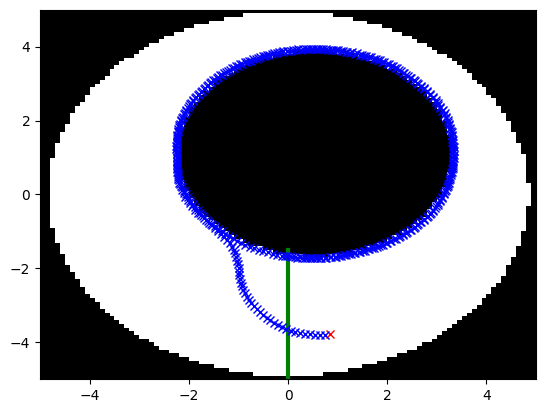

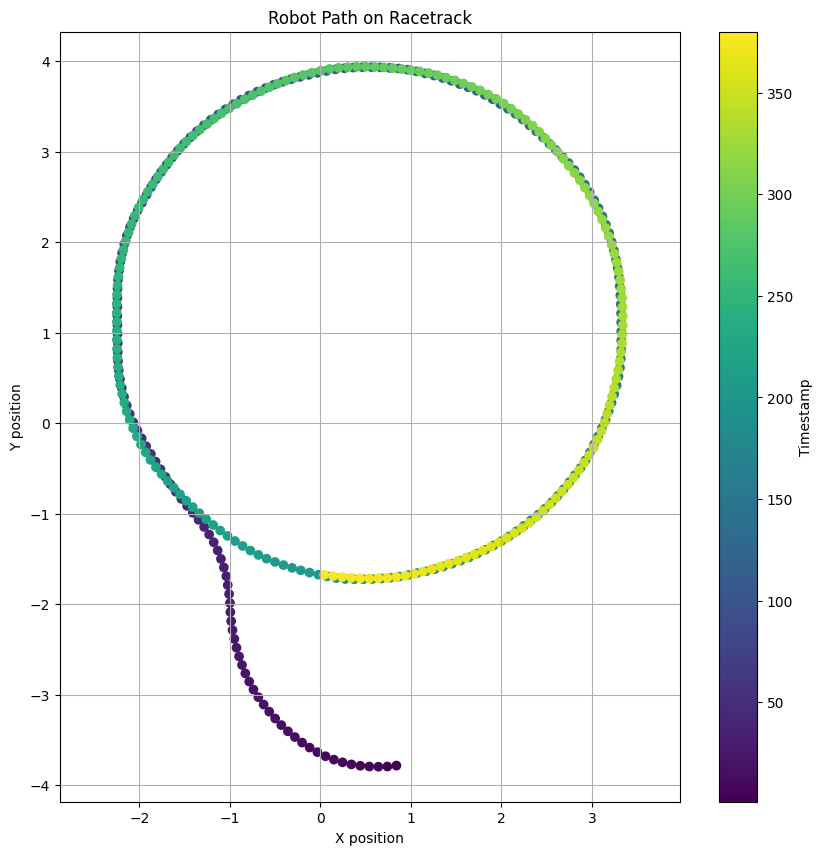

379

In [12]:
seed = 0
num_laps = 3
planner_class = BetterPlanner
run_planner_on_racetrack(
    env, planner_class=planner_class, seed=seed, num_laps=num_laps
)

# Problem 2: Trajectory Optimization with `cvxpy`

## 2a) Double Integrator: Initial & Terminal Conditions

For this problem, you'll use the 2D discrete-time double integrator dynamics, where $$\mathbf{x}[t] = \begin{bmatrix}
x[t]\\
y[t]\\
v_x[t]\\
v_y[t]\\
\end{bmatrix}, \quad \mathbf{u}[t] = \begin{bmatrix} a_x[t]\\ a_y[t]\\ \end{bmatrix}, \quad \mathbf{x}[t+dt] = A \mathbf{x}[t] +  B \mathbf{u}[t], \quad A = \begin{bmatrix}
1 & 0 & dt & 0 \\
0 & 1 & 0 & dt \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1 \\
\end{bmatrix}, \quad B = \begin{bmatrix}
\frac{dt^2}{2} & 0 \\
0 & \frac{dt^2}{2} \\
dt & 0 \\
0 & dt \\
\end{bmatrix}.
$$

You should turn the following optimization problem into code:

$$
\begin{align}
\min_{x_{0:T}, u_{0:T}}\quad & (x[T] - g_x)^2 + (y[T] - g_y)^2 \\
\text{s.t.}\quad & \mathbf{x}[t+1] = A \mathbf{x}[t] + B \mathbf{u}[t] \quad \forall t \in \{0, 1, \ldots, T-1\} \\
& \mathbf{u}[t] \in U \quad \forall t \in \{0, 1, \ldots, T-1\} \\
& \mathbf{x}[0] = \mathbf{x}_0 \\
& v_x[T] = v_{x,T} \\
& v_x[T] = v_{y,T} \\
\end{align}
$$

with $g_x = 3, g_y=5, v_{x,T}=0, v_{y,T}=0, \mathbf{x}_0 = [1, 2, 0, 0], U = [-1, 1] \times [-1, 1], T=10$.

**Deliverables**:
- Implement `optimize_trajectory`, which will take in initial and terminal conditions, control limits, dt, and return the optimal sequence of states (i.e., an array of shape (T+1, 4) -- T+1 timesteps (T timesteps + the initial state) and 4 states per timestep)
- Generate a plot of your optimal trajectory. You are welcome to use the `plot_trajectory` function or write your own version.

In [13]:
def optimize_trajectory(
    initial_pos: np.ndarray,
    initial_vel: np.ndarray,
    goal_pos: np.ndarray,
    goal_vel: np.ndarray,
    u_limits: np.ndarray,
    dt: float,
) -> np.ndarray:

    T = 10  # Number of time steps (given)
    n = 4   # Number of states x[t]
    m = 2   # Number of control inputs u[t]

    # Define system matrices
    A = np.array([
        [1, 0, dt, 0],
        [0, 1, 0, dt],
        [0, 0, 1, 0],
        [0, 0, 0, 1]])

    B = np.array([
        [0.5 * dt**2, 0],
        [0, 0.5 * dt**2],
        [dt, 0],
        [0, dt]])

    x = cp.Variable((T+1, n)) # State trajectory over time
    u = cp.Variable((T, m)) # Control input over time

    # Define constraints
    constraints = []
    for t in range(T):
        constraints.append(x[t+1] == A @ x[t] + B @ u[t])  # System dynamics
        constraints.append(cp.abs(u[t]) <= u_limits[:, 1])  # Control limits

    # Initial and terminal conditions
    constraints.append(x[0, :2] == initial_pos)
    constraints.append(x[0, 2:] == initial_vel)
    constraints.append(x[T, 2:] == goal_vel)

    # Define objective function
    objective = cp.sum_squares(x[T, :2] - goal_pos)

    # Define and solve the problem
    problem = cp.Problem(cp.Minimize(objective), constraints)
    problem.solve()

    # Check if the problem was solved
    if problem.status == cp.OPTIMAL:
      print("Optimal solution found!")
    else:
      print("Failed to find an optimal solution.")

    states = x.value

    return states


def plot_trajectory(xt: np.ndarray) -> None:

    # Feel free to add to this

    plt.plot(xt[:, 0], xt[:, 1], "-x")
    plt.plot(xt[0, 0], xt[0, 1], 'go', label='Start')
    plt.plot(xt[-1, 0], xt[-1, 1], 'ro', label='Goal')
    plt.xlabel('X position')
    plt.ylabel('Y position')
    plt.title('Optimal Trajectory')
    plt.axis("equal")
    plt.show()

You can check whether your code works using

Optimal solution found!


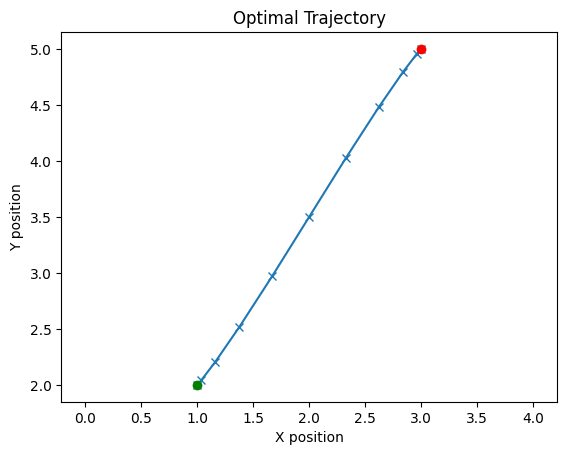

In [14]:
initial_pos = np.array([1.0, 2.0])
initial_vel = np.array([0.0, 0.0])
goal_pos = np.array([3.0, 5.0])
goal_vel = np.array([0.0, 0.0])
u_limits = 0.2 * np.array([[-1.0, 1.0], [-1.0, 1.0]])
dt = 1.0

optimal_xt = optimize_trajectory(
    initial_pos,
    initial_vel,
    goal_pos,
    goal_vel,
    u_limits,
    dt,
)

plot_trajectory(optimal_xt)

## [Extra Credit] 2b) Incorporate obstacle avoidance as a convex optimization problem

Now, you should extend your optimization code to handle a list of circular obstacles that the double integrator must avoid. We would like you to try to keep this as a convex optimization problem. If you just start adding constraints and costs, you will likely end up with a non-convex optimization problem, which are generally hard to solve.

One possible way to keep the problem convex could be to break the free (i.e., non-obstacle) space into a set of convex regions, then split the trajectory into multiple segments (each one needing to stay within one convex region). But, there could be many other ways, and you are encouraged to try different strategies!


**SOLUTION:** The idea here was to add intermediate points so that the convex regions can be split. The number of intermediate points will be equal to the number of obstacles. For each obstacle, an intermediate point is chosen by:

    -Computing a perpendicular vector to the global path direction

    -Placing the point at a distance of 'radius' + 'safe_distance' along this perpendicular vector

    -Determining the side of placement based on the obstacle's position relative to the path
    
The intermediate points are positioned perpendicular to the obstacles, which creates a more natural avoidance behavior as seen in the trajectory plot.

In [82]:
def optimize_trajectory_with_obstacles(
    initial_pos: np.ndarray,
    initial_vel: np.ndarray,
    goal_pos: np.ndarray,
    goal_vel: np.ndarray,
    u_limits: np.ndarray,
    dt: float,
    obstacles: list,
) -> np.ndarray:


    def generate_intermediate_points(obstacles, initial_pos, goal_pos):
        points = []
        safe_distance = 1.5

        # Add initial position
        points.append(initial_pos)

        for i, obstacle in enumerate(obstacles):
            obs_x, obs_y, obs_r = obstacle

            # Calculate tangent points to create a wider berth around obstacles
            if i < len(obstacles) - 1:
                next_obs = obstacles[i + 1]
                # Vector between current and next obstacle
                obs_vector = np.array([next_obs[0] - obs_x, next_obs[1] - obs_y])
                obs_dist = np.linalg.norm(obs_vector)

                # Calculate perpendicular offset
                perp = np.array([-obs_vector[1], obs_vector[0]]) / obs_dist
                offset = (obs_r + safe_distance) * perp

                # Create two intermediate points around the obstacle
                point1 = np.array([obs_x, obs_y]) + offset
                point2 = np.array([obs_x, obs_y]) + offset + obs_vector * 0.3

                points.extend([point1, point2])
            else:
                # For last obstacle, create point towards goal
                to_goal = goal_pos - np.array([obs_x, obs_y])
                to_goal_norm = to_goal / np.linalg.norm(to_goal)
                point = np.array([obs_x, obs_y]) + (obs_r + safe_distance) * to_goal_norm
                points.append(point)

        # Add goal position
        points.append(goal_pos)

        return points



    def optimize_segment(start_pos, start_vel, end_pos, end_vel):
        T = 10
        n = 4
        m = 2
        A = np.array([[1, 0, dt, 0],
                      [0, 1, 0, dt],
                      [0, 0, 1, 0],
                      [0, 0, 0, 1]])

        B = np.array([[0.5*dt**2, 0],
                     [0, 0.5*dt**2],
                     [dt, 0],
                     [0, dt]])

        x = cp.Variable((T+1, n))
        u = cp.Variable((T, m))
        constraints = []
        for t in range(T):
            constraints.append(x[t+1] == A @ x[t] + B @ u[t])
            constraints.append(cp.abs(u[t]) <= u_limits[:, 1])

        constraints.append(x[0, :2] == start_pos)
        constraints.append(x[0, 2:] == start_vel)
        constraints.append(x[T, :2] == end_pos)
        constraints.append(x[T, 2:] == end_vel)

        objective = cp.sum_squares(x[T, :2] - end_pos)
        problem = cp.Problem(cp.Minimize(objective), constraints)
        problem.solve()
        return x.value

    # Generate intermediate points
    intermediate_points = generate_intermediate_points(obstacles, initial_pos,goal_pos) # Intermediate points equal to obstacles
    all_points = [initial_pos] + intermediate_points + [goal_pos]

    # Initialize complete trajectory
    complete_trajectory = []

    # Optimize through each segment
    for i in range(len(all_points)-1):
        start_pos = all_points[i]
        end_pos = all_points[i+1]
        start_vel = initial_vel
        end_vel = goal_vel

        segment = optimize_segment(start_pos, start_vel, end_pos, end_vel)

        if i == 0:
            complete_trajectory.extend(segment)
        else:
            complete_trajectory.extend(segment[1:])

    return np.array(complete_trajectory)

def plot_trajectory_with_obstacles(
    xt: np.ndarray,
    obstacles: list,
) -> None:
    fig, ax = plt.subplots()
    plt.plot(xt[:, 0], xt[:, 1], "-x")
    for obstacle in obstacles:
        ax.add_patch(plt.Circle(obstacle[0:2], obstacle[2], color="r"))
    plt.axis("equal")
    plt.show()


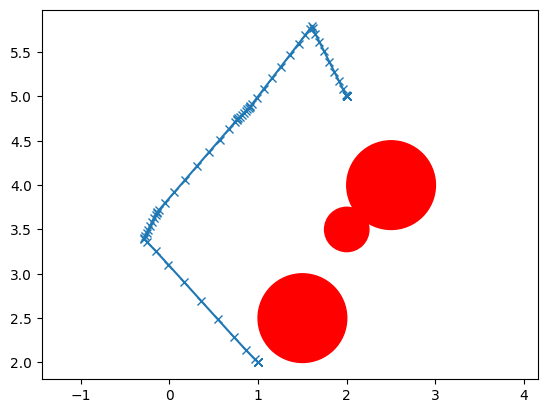

In [83]:
initial_pos = np.array([1.0, 2.0])
initial_vel = np.array([0.0, 0.0])
goal_pos = np.array([2, 5.0])
goal_vel = np.array([0.0, 0.0])
u_limits = 0.2 * np.array([[-1.0, 1.0], [-1.0, 1.0]])
dt = 1.0

obstacles = [
    (1.5, 2.5, 0.5),
    (2.0, 3.5, 0.25),
    (2.5, 4.0, 0.5),
]

optimal_xt = optimize_trajectory_with_obstacles(
    initial_pos,
    initial_vel,
    goal_pos,
    goal_vel,
    u_limits,
    dt,
    obstacles,
)

plot_trajectory_with_obstacles(optimal_xt, obstacles)